<a href="https://colab.research.google.com/github/MadmanMarble/GLAP/blob/main/MidTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mid Term Project
##Description of the mid term project: this project implements linear regression from scratch with stochastic gradient descent, without using a library function except of course the necessary functions for array processing and autograd. The given code implements linear regression with the MSE loss function and the assignment is to experiment with other loss functions.
***Notes***: The linear regression code for this notebook is based on ***3.2. Linear Regression Implementation from Scratch*** of the [Dive into Deep Learning Book](https://d2l.ai/index.html)

In [1]:
!pip install -U d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 791.7 kB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Un

In [ ]:
# Email from professor

# In the mid term project a common question has been: how to create outliers in the synthetic data?
# One way to do that is to generate random numbers from torch.normal (which is used in the
# code for the main distribution) using a large standard deviation (e.g. 5) and add that to
# a subset (e.g. 100 out of 1000) of the y-values that are generated from the main normal distribution


# in class notes from monday 9/16
# this does not effect the assignemnt (just to write about it)

# for jakevdp notebook, there's an error in def hours_of_daylight


# the correct line should be
# days = (date - pd.Timestamp(2000, 12, 21)).days

# it was originally pd.datetime or something similar


In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [2]:
# this function generates some values that correspond to a linear function
# this is to use sythetic data to explore linear regression
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # generating noise
    return X, y.reshape((-1, 1))

# the weight is chosen as two values. if you change them you will get a different line
# the bias is 4.2
# the
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # 1000 is the number of the data points chosen

In [3]:
# this is just an example to show us features at their location and thier values
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.0608, 0.2398]) 
label: tensor([3.5031])


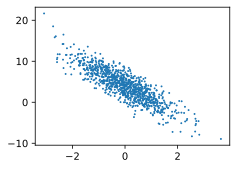

In [4]:
# lets plot the sythetic data that has been generated
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [5]:
# this is going through different iterations through the data ??
# this is doing the selection
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [6]:
batch_size = 10 # selecting just 10 out of the 1000 that were generated

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0252,  1.8961],
        [ 0.8723,  0.3105],
        [-0.5018,  0.3044],
        [ 0.4658,  1.5040],
        [-0.3570, -0.1851],
        [-0.4563,  0.6722],
        [ 0.0123, -0.3458],
        [-3.3324,  0.3390],
        [-1.1951,  0.3496],
        [-1.6848,  0.3262]]) 
 tensor([[-2.2985],
        [ 4.9140],
        [ 2.1464],
        [ 0.0235],
        [ 4.1079],
        [ 0.9952],
        [ 5.3993],
        [-3.6107],
        [ 0.6256],
        [-0.2841]])


In [7]:
# our goal is to find the best values for w and b given the dataset that we have
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [10]:
# stocastic gradient descent
# the initial slope and intersept points could be random
# sgd is trying to get the line closer to the best fit line
# you want to step to the lower loss value
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [11]:
lr = 0.03 # learning rate. determines the amount of change each time we change the slope and intercept.
# small steps give higher change of not missing the global minimum. bigger steps get you there fast, but you might step over/around it.
num_epochs = 3 # the number of times you iterate. how many times are we stepping the learning rate
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.049909
epoch 2, loss 0.000229
epoch 3, loss 0.000049


In [12]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([1.4577e-03, 5.7697e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0004], grad_fn=<RsubBackward1>)


#Assigned tasks:
##The MSE loss function is not the only loss function for linear regression. To be robust to outliers in the training data, the Huber loss and the Log-Cosh are used. Your task is to implement both loss functions in addition to the given MSE loss function (named squared_loss) of this notebook, and to compare their performance on data with outliers. The specific tasks are as follows -
1.   Add two more code cells - one that defines the Huber loss function, and another with defines the Log-Cosh. This [blog post](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0) describes these loss functions and provides code which is written in numpy so it will need to changed to compatible with PyTorch.
2.   Inject outliers in the data generated by the synthetic data generator of this notebook. You could add random noise to the existing data objects, i.e. changing a given percentage of the data entries to random values within the data range. Inclusion of these outliers will let you compare the benefits of these two loss functions against the MSE.
3.   Create a text cell to summarize your experimental observations as follows: (1) note how many outliers you added (2) compare the error in estimating w and b between MSE, Huber loss, and Log-Cosh loss.







In [ ]:
# Define the Huber loss function using PyTorch
def huber(true, pred, delta):
    abs_diff = torch.abs(true - pred)
    loss = torch.where(abs_diff < delta, 0.5 * (abs_diff ** 2), delta * abs_diff - 0.5 * (delta ** 2))
    return torch.sum(loss)

In [ ]:
# 1 hr 40 min for log cosh info

In [ ]:
import torch

def log_cosh(x):
    return torch.log(torch.cosh(x))

#Assigned tasks:
##This is not a coding task. Create a text cell below this cell, go through the Jake VDP linear regression notebook and write in your own words (2 -3 paragraphs):


*   Different regression techniques presented in the notebook.
*   Think of a problem similar to predicting bicycle traffic and describe how you would solve it with regression.









text cell placeholder for my comments about the Jake VDP linear regression notebook.
Just high level details - an idea of what the variables will be and what to predict. it has to be a linear regression problem. all he's looking for is a practical problem that can be solved linear regression. you can include citations and sources too.  